In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

Import dfs

In [3]:
df_compras = pd.read_csv("df_compras.csv")
df_estoque = pd.read_csv("df_estoque.csv")
df_lead_times = pd.read_csv("df_lead_times.csv")
df_produtos = pd.read_csv("df_produtos.csv")
df_vendas = pd.read_excel("df_vendas.xlsx")

Análise DF compras

In [4]:
df_compras

,Unnamed: 0,Data,Produto_ID,Fornecedor_ID,Quantidade_Compra,Status
0,0,2018-01-01,1,1,43,Em Trânsito
1,1,2018-01-01,2,2,25,Entregue
2,2,2018-01-01,3,3,49,Aguardando Confirmação
3,3,2018-01-01,4,4,34,Em Trânsito
4,4,2018-01-01,5,5,36,Em Trânsito
...,...,...,...,...,...,...
18255,18255,2022-12-31,6,6,33,Aguardando Confirmação
18256,18256,2022-12-31,7,7,40,Em Trânsito
18257,18257,2022-12-31,8,8,10,Em Trânsito
18258,18258,2022-12-31,9,9,22,Entregue


In [5]:
df_compras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18260 entries, 0 to 18259
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         18260 non-null  int64 
 1   Data               18260 non-null  object
 2   Produto_ID         18260 non-null  int64 
 3   Fornecedor_ID      18260 non-null  int64 
 4   Quantidade_Compra  18260 non-null  int64 
 5   Status             18260 non-null  object
dtypes: int64(4), object(2)
memory usage: 856.1+ KB


A tabela de compras possui 4 colunas se desconsiderarmos a coluna inicial que traz o indice. A coluna de data de compra, id do produto, id do fornecedor e a quantidade de compra. Nenhum campo está nulo.

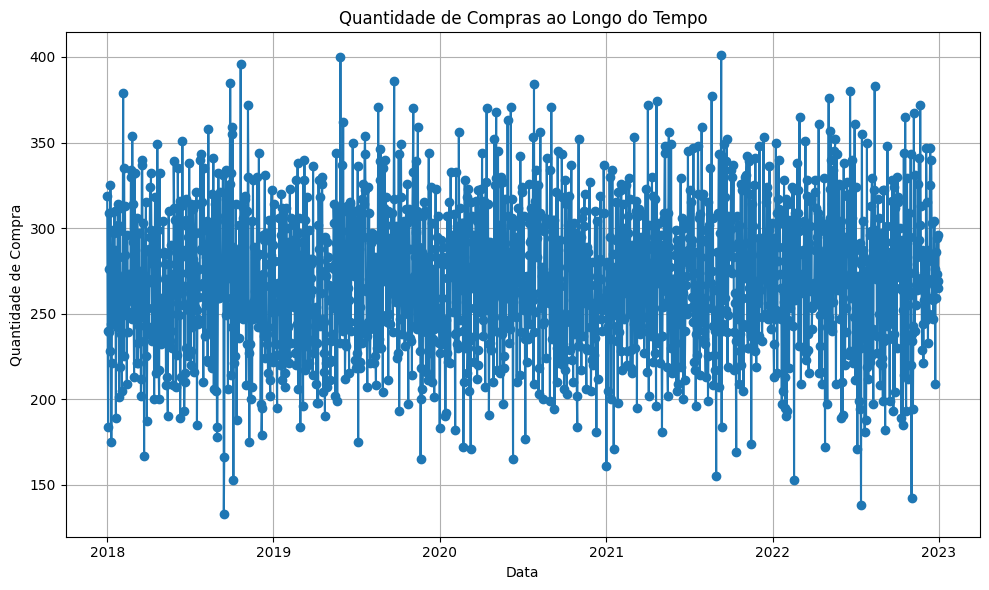

In [6]:
df_compras['Data_tratada'] = pd.to_datetime(df_compras['Data'])
df_grouped = df_compras.groupby('Data_tratada')['Quantidade_Compra'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(df_grouped['Data_tratada'],df_grouped['Quantidade_Compra'], marker='o')
plt.title('Quantidade de Compras ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Quantidade de Compra')
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
min(df_compras['Data_tratada'])

Timestamp('2018-01-01 00:00:00')

In [8]:
max(df_compras['Data_tratada'])

Timestamp('2022-12-31 00:00:00')

O período de compra abrange de 2018 até o final de 2022. As compras parecem não apresentar nenhuma tendência ao longo do tempo, e as unidades compradas por dia oscilaram entre próximo de 150 até 400.

In [9]:
df_compras['Produto_ID'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [10]:
df_compras['Fornecedor_ID'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

Temos 10 produtos e 10 fornecedores na base.

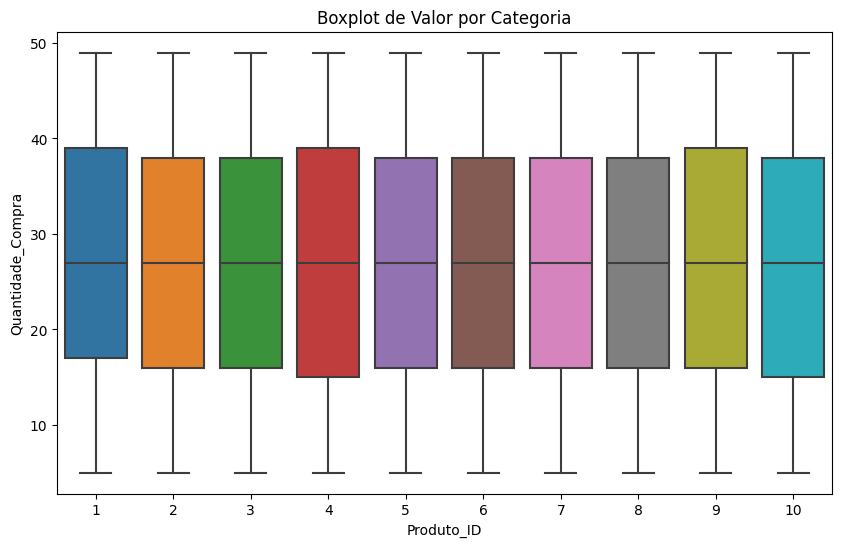

In [11]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df_compras['Produto_ID'], y=df_compras['Quantidade_Compra'], data=df_compras)
plt.title('Boxplot de Valor por Categoria')
plt.show()

As quantidade compradas por produto mantiveram quase a mesma distribuição. Com uma média de quase 30 itens comprados por produto quando ocorre a venda. Também notamos que não temos outliers na base.

Análise do DF Estoque

In [12]:
df_estoque.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18260 entries, 0 to 18259
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          18260 non-null  int64 
 1   Data                18260 non-null  object
 2   Produto_ID          18260 non-null  int64 
 3   Quantidade_Estoque  18260 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 570.8+ KB


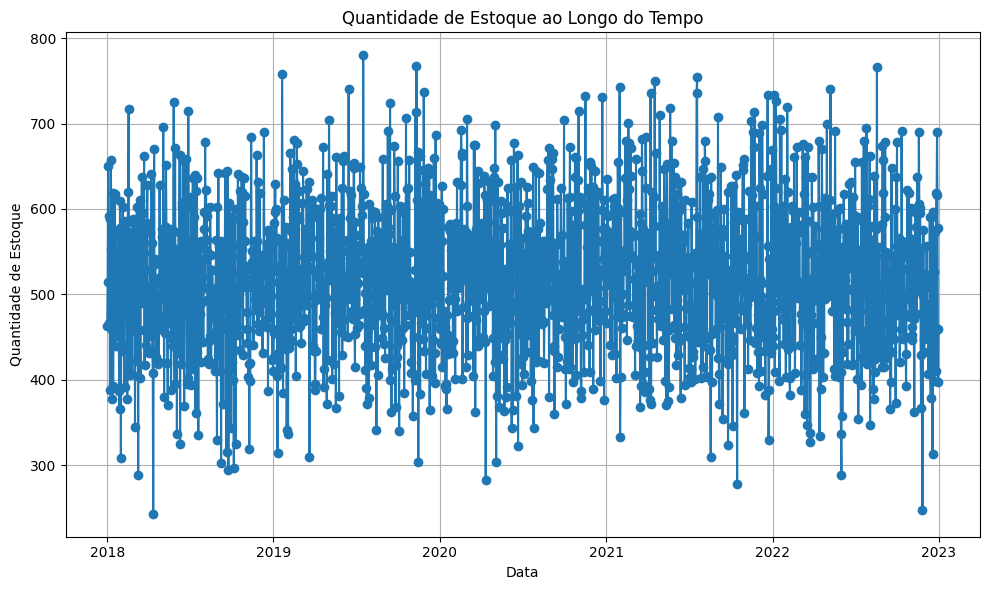

In [13]:
df_estoque['Data_tratada'] = pd.to_datetime(df_estoque['Data'])
df_grouped = df_estoque.groupby('Data_tratada')['Quantidade_Estoque'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df_grouped['Data_tratada'], df_grouped['Quantidade_Estoque'], marker='o')
plt.title('Quantidade de Estoque ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Quantidade de Estoque')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
min(df_estoque['Data_tratada'])

Timestamp('2018-01-01 00:00:00')

In [15]:
max(df_estoque['Data_tratada'])

Timestamp('2022-12-31 00:00:00')

O estoque também não apresenta nenhuma tendência. Os valores oscilam entre próximos de 300 e 700, e o período compreendido é também de 2018 até final de 2022.

In [16]:
df_estoque['Produto_ID'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

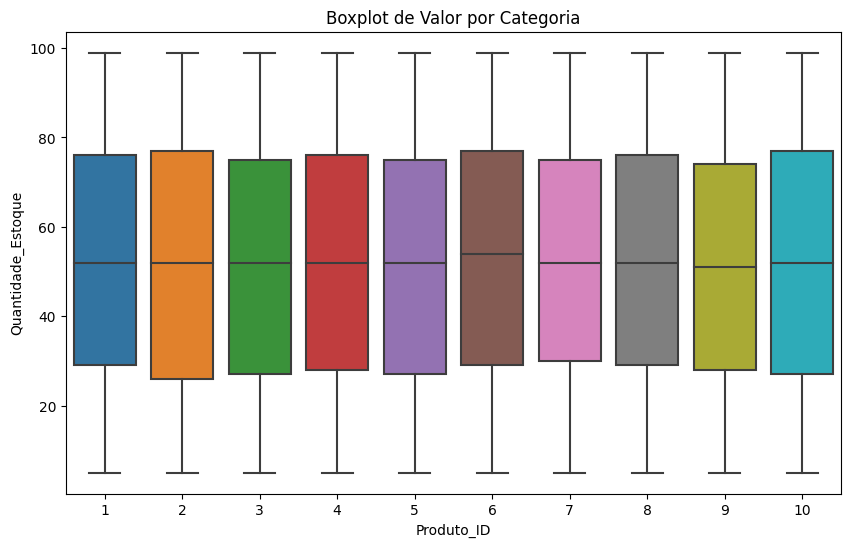

In [17]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df_estoque['Produto_ID'], y=df_estoque['Quantidade_Estoque'], data=df_estoque)
plt.title('Boxplot de Valor por Categoria')
plt.show()

Há também apenas 10 produtos na base de estoque e a distribuição dos valores de estoque destes produtos é similar, com uma média próxima a 50 nos dias em que houve medição.

Análise Lead Times

In [18]:
df_lead_times

,Unnamed: 0,Fornecedor_ID,Produto_ID,Lead_Time_Dias,Criticidade
0,0,1,1,9,0
1,1,11,1,9,0
2,2,2,2,11,1
3,3,3,3,9,0
4,4,13,3,12,0
5,5,4,4,14,0
6,6,14,4,10,0
7,7,5,5,8,1
8,8,16,6,14,0
9,9,6,6,11,0


Para todos os produtos que possuem mais de um fornecedor a criticidade é marcada como 0, contudo, se há apenas um fornecedor para determinado produto a criticidade é marcada como 1, há apenas 2 produtos que possuem essa criticidade.

In [19]:
df_lead_times.describe()

,Unnamed: 0,Fornecedor_ID,Produto_ID,Lead_Time_Dias,Criticidade
count,18.000000,18.000000,18.000000,18.000000,18.000000
mean,8.500000,10.166667,5.722222,9.833333,0.111111
std,5.338539,6.138116,2.986352,2.684377,0.323381
min,0.000000,1.000000,1.000000,6.000000,0.000000
25%,4.250000,5.250000,3.250000,8.000000,0.000000
50%,8.500000,9.500000,6.000000,9.000000,0.000000
75%,12.750000,15.500000,8.000000,11.750000,0.000000
max,17.000000,20.000000,10.000000,14.000000,1.000000


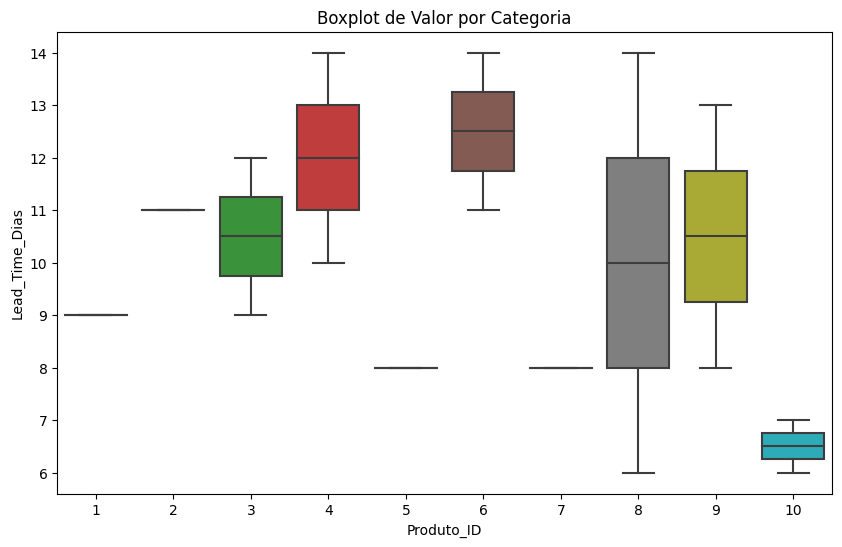

In [20]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df_lead_times['Produto_ID'], y=df_lead_times['Lead_Time_Dias'], data=df_lead_times)
plt.title('Boxplot de Valor por Categoria')
plt.show()

Os produtos apresentam lead times de entrega bem distintos variando de 6 dias até 14.

Análise Df Produtos

In [21]:
df_produtos.describe()

,Unnamed: 0,Produto_ID,Custo_Unitario
count,10.00000,10.00000,10.000000
mean,4.50000,5.50000,28.700000
std,3.02765,3.02765,12.347289
min,0.00000,1.00000,12.000000
25%,2.25000,3.25000,20.000000
50%,4.50000,5.50000,26.000000
75%,6.75000,7.75000,40.500000
max,9.00000,10.00000,47.000000


In [22]:
df_produtos

,Unnamed: 0,Produto_ID,Nome_Produto,Custo_Unitario
0,0,1,Produto_1,43
1,1,2,Produto_2,33
2,2,3,Produto_3,19
3,3,4,Produto_4,47
4,4,5,Produto_5,12
5,5,6,Produto_6,25
6,6,7,Produto_7,43
7,7,8,Produto_8,23
8,8,9,Produto_9,27
9,9,10,Produto_10,15


Este df é bem simples, traz o nome dos 10 produtos, contudo, como os nomes são ficticios a única informação que vale analisar é o custo unitário.

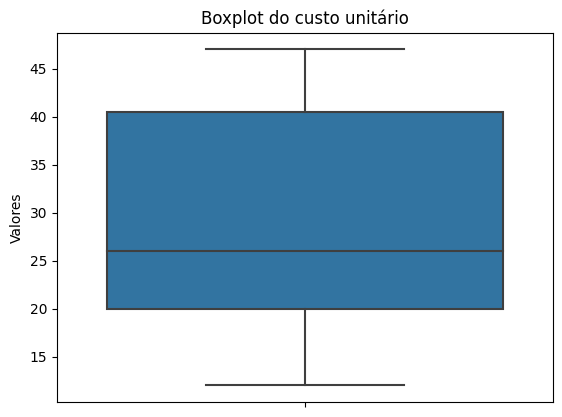

In [23]:
sns.boxplot(y=df_produtos['Custo_Unitario'])
plt.title('Boxplot do custo unitário')
plt.ylabel('Valores')
plt.show()

A média de custo unitário é de 28, o primeiro quartil fica em 20 e o terceiro quartil é de 40.

DF_Vendas

In [24]:
df_vendas

,Produto_ID,Data,Quantidade Vendida
0,1,2018-01-01,4
1,1,2018-01-02,6
2,1,2018-01-03,6
3,1,2018-01-04,10
4,1,2018-01-05,9
...,...,...,...
18255,10,2022-12-27,30
18256,10,2022-12-28,30
18257,10,2022-12-29,31
18258,10,2022-12-30,29


In [25]:
df_vendas['Produto_ID'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [26]:
df_vendas.describe()

,Produto_ID,Quantidade Vendida
count,18260.00000,18260.000000
mean,5.50000,58.814951
std,2.87236,44.802008
min,1.00000,0.000000
25%,3.00000,24.000000
50%,5.50000,46.000000
75%,8.00000,88.000000
max,10.00000,220.000000


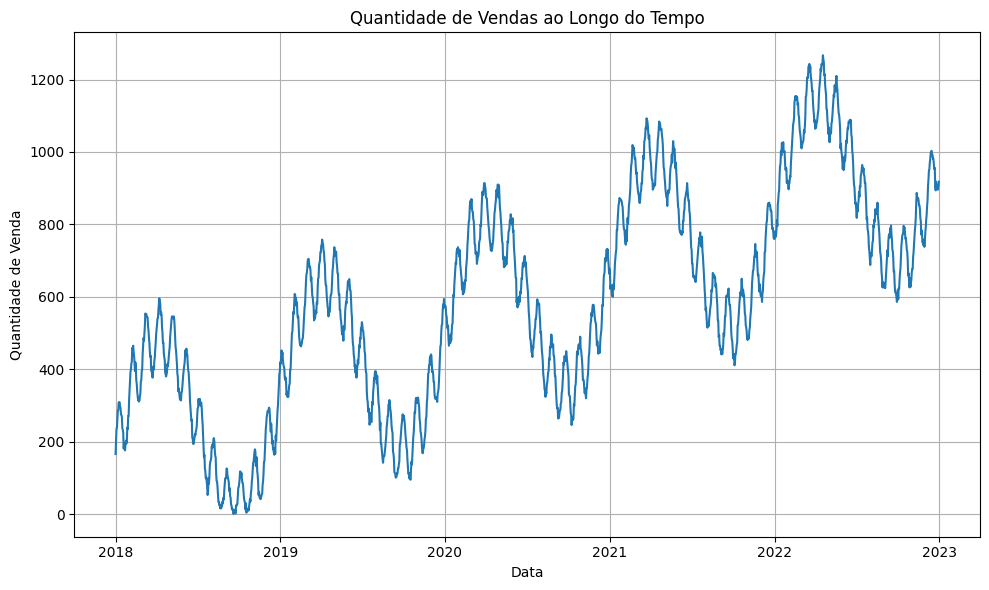

In [27]:
df_vendas['Data_tratada'] = pd.to_datetime(df_vendas['Data'])
df_grouped = df_vendas.groupby('Data_tratada')['Quantidade Vendida'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df_grouped['Data_tratada'], df_grouped['Quantidade Vendida'])
plt.title('Quantidade de Vendas ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Quantidade de Venda')
plt.grid(True)
plt.tight_layout()
plt.show()

O gráfico apresenta uma tendência de alta nas vendas, vamos quebrar por produto.

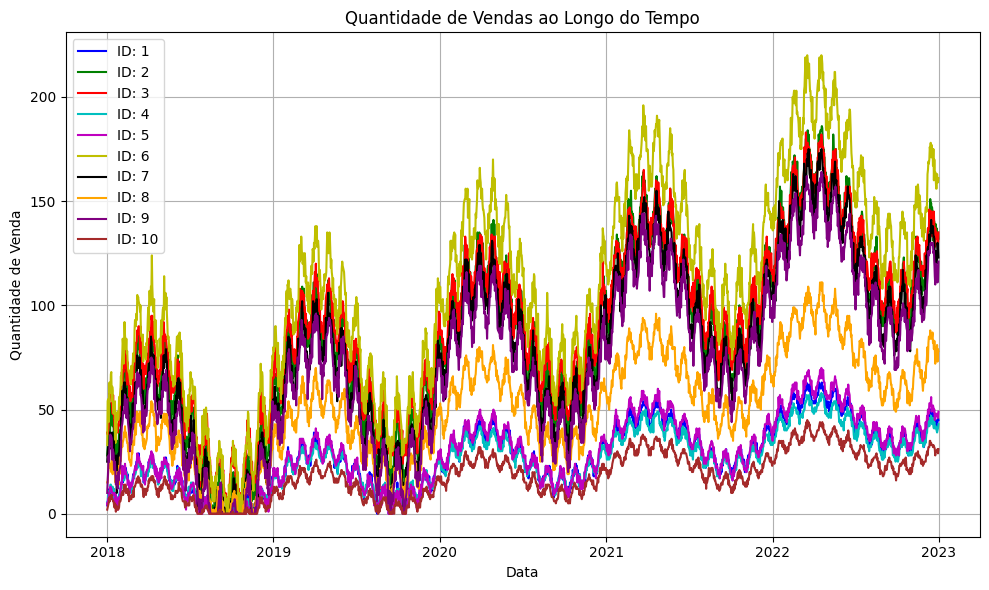

In [28]:
# Lista de cores (pode ser estendida de acordo com o número de IDs que você tem)
cores = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

# Agrupando por Data_tratada e ID_Produto
df_grouped = df_vendas.groupby(['Data_tratada', 'Produto_ID'])['Quantidade Vendida'].sum().reset_index()

plt.figure(figsize=(10, 6))

for idx, (product_id, group) in enumerate(df_grouped.groupby('Produto_ID')):
    plt.plot(group['Data_tratada'], group['Quantidade Vendida'], color=cores[idx % len(cores)], label=f'ID: {product_id}')

plt.title('Quantidade de Vendas ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Quantidade de Venda')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Para todos produtos notamos que há uma tendência de alta, contudo esse efeito é mais forte em alguns produtos do que em outros. Por exemplo, o produto 6 apresenta uma tendência mais forte do que o produto 10.

Criação do modelo

In [29]:
# Função para calcular estoque mínimo
def calcular_estoque_minimo(demanda_mensal, lead_time, numero_fornecedores):
    if numero_fornecedores == 1:
        seguranca = 1.5  #Aumentando o estoque de segurança para produtos com apenas um fornecedor
    else:
        seguranca = 1.2

    #Estoque mínimo = demanda diária x lead time x fator de segurança
    estoque_minimo = (demanda_mensal / 30) * lead_time * seguranca

    return estoque_minimo

In [30]:
def remove_duplicates(data):
    return data.loc[~data.index.duplicated(keep='first')]

In [31]:
df_vendas.drop(columns='Data_tratada',inplace=True)

<ipython-input-32-c872dd2ce02b>:6: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_vendas.fillna(df_vendas.mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


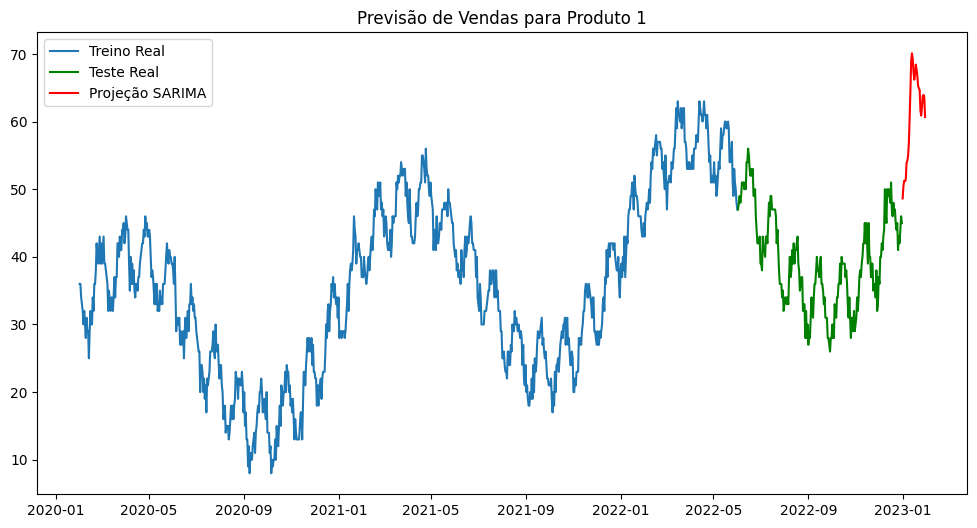

{1: {'MSE': 193.69701806749242, 'RMSE': 13.917507609751555, 'MAE': 12.262648671468664}}


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


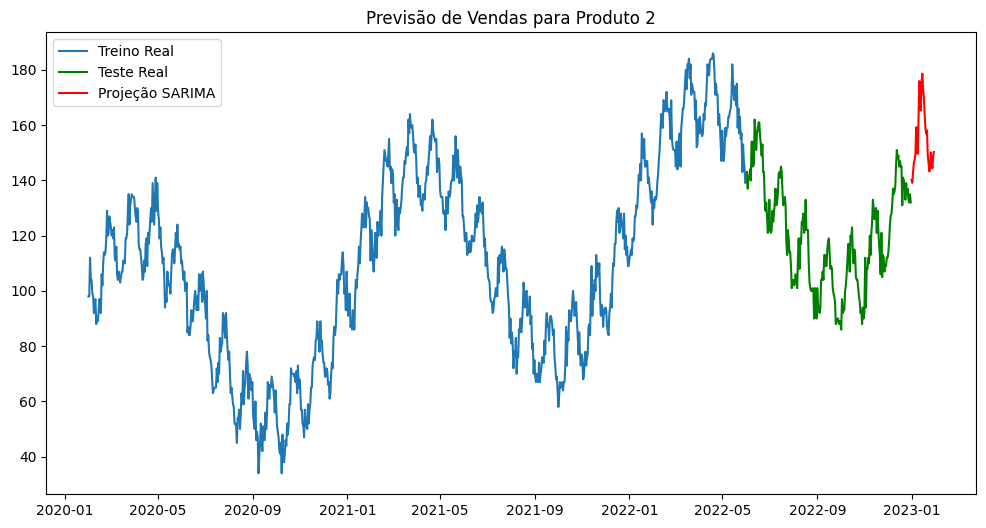

{1: {'MSE': 193.69701806749242, 'RMSE': 13.917507609751555, 'MAE': 12.262648671468664}, 2: {'MSE': 156.30028982725008, 'RMSE': 12.502011431255776, 'MAE': 10.445893637797905}}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


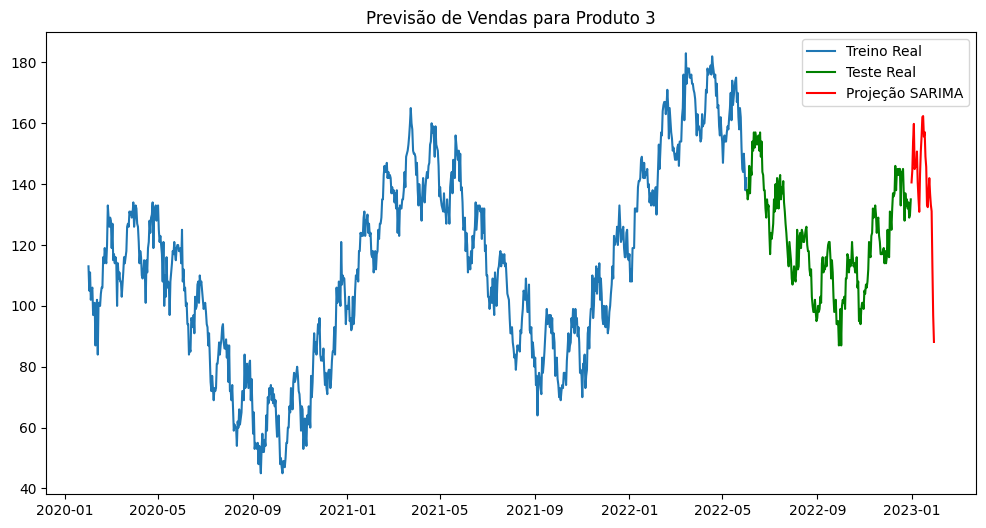

{1: {'MSE': 193.69701806749242, 'RMSE': 13.917507609751555, 'MAE': 12.262648671468664}, 2: {'MSE': 156.30028982725008, 'RMSE': 12.502011431255776, 'MAE': 10.445893637797905}, 3: {'MSE': 177.99019991144948, 'RMSE': 13.341296785224797, 'MAE': 9.611508412538653}}


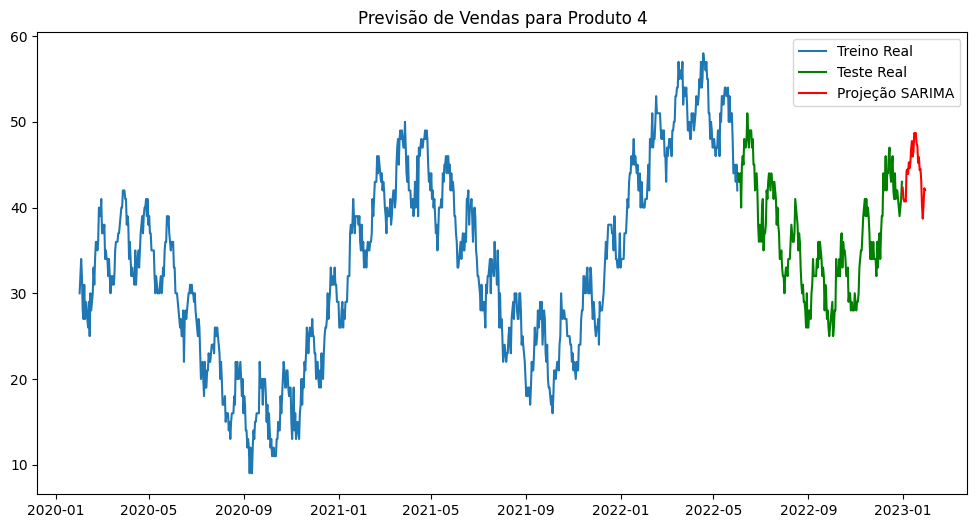

{1: {'MSE': 193.69701806749242, 'RMSE': 13.917507609751555, 'MAE': 12.262648671468664}, 2: {'MSE': 156.30028982725008, 'RMSE': 12.502011431255776, 'MAE': 10.445893637797905}, 3: {'MSE': 177.99019991144948, 'RMSE': 13.341296785224797, 'MAE': 9.611508412538653}, 4: {'MSE': 4.663619642478364, 'RMSE': 2.1595415352519534, 'MAE': 1.7310748280174737}}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


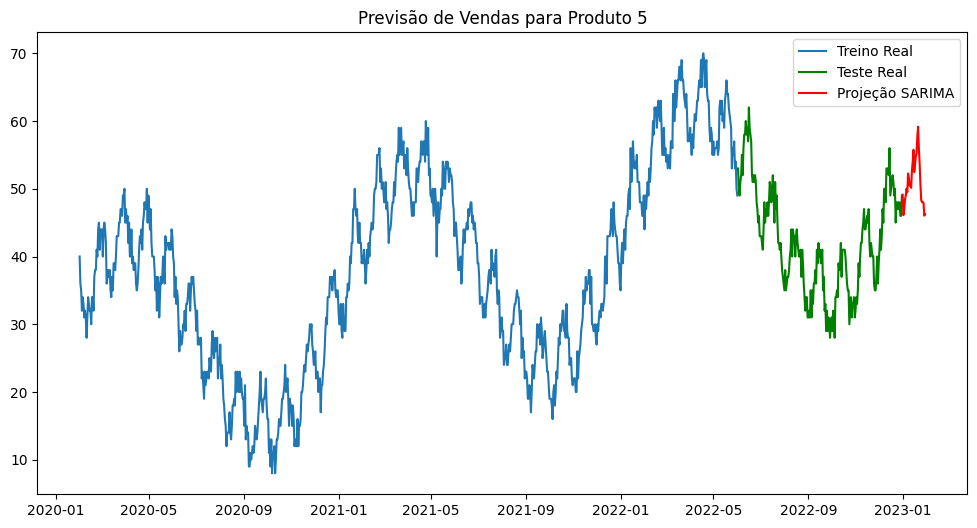

{1: {'MSE': 193.69701806749242, 'RMSE': 13.917507609751555, 'MAE': 12.262648671468664}, 2: {'MSE': 156.30028982725008, 'RMSE': 12.502011431255776, 'MAE': 10.445893637797905}, 3: {'MSE': 177.99019991144948, 'RMSE': 13.341296785224797, 'MAE': 9.611508412538653}, 4: {'MSE': 4.663619642478364, 'RMSE': 2.1595415352519534, 'MAE': 1.7310748280174737}, 5: {'MSE': 22.218885416928064, 'RMSE': 4.713691272975784, 'MAE': 4.1091267824938305}}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


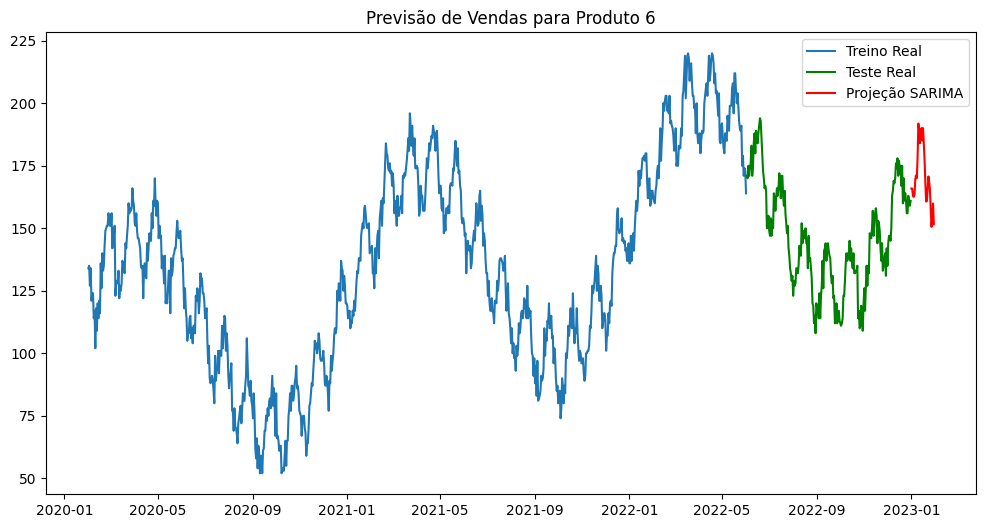

{1: {'MSE': 193.69701806749242, 'RMSE': 13.917507609751555, 'MAE': 12.262648671468664}, 2: {'MSE': 156.30028982725008, 'RMSE': 12.502011431255776, 'MAE': 10.445893637797905}, 3: {'MSE': 177.99019991144948, 'RMSE': 13.341296785224797, 'MAE': 9.611508412538653}, 4: {'MSE': 4.663619642478364, 'RMSE': 2.1595415352519534, 'MAE': 1.7310748280174737}, 5: {'MSE': 22.218885416928064, 'RMSE': 4.713691272975784, 'MAE': 4.1091267824938305}, 6: {'MSE': 89.1249323985367, 'RMSE': 9.440600213891948, 'MAE': 6.853081309630893}}


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


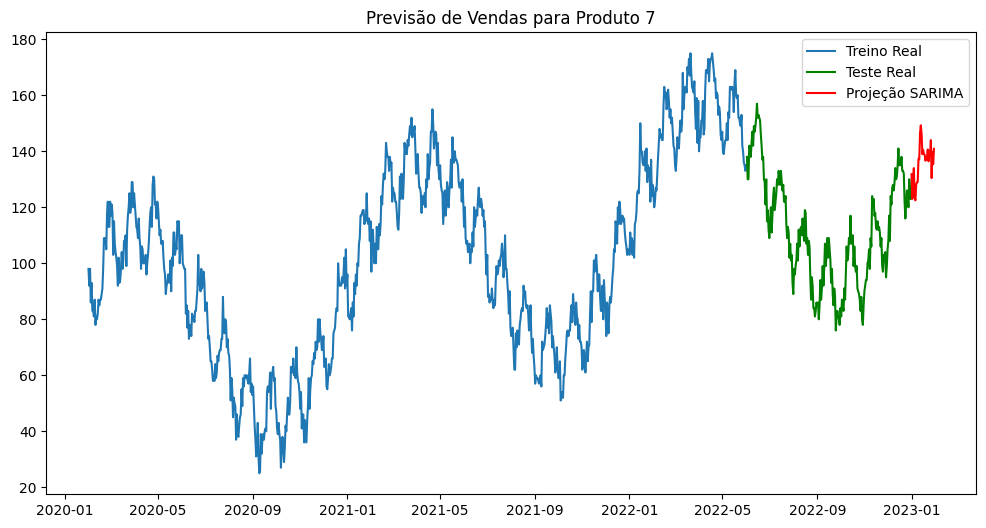

{1: {'MSE': 193.69701806749242, 'RMSE': 13.917507609751555, 'MAE': 12.262648671468664}, 2: {'MSE': 156.30028982725008, 'RMSE': 12.502011431255776, 'MAE': 10.445893637797905}, 3: {'MSE': 177.99019991144948, 'RMSE': 13.341296785224797, 'MAE': 9.611508412538653}, 4: {'MSE': 4.663619642478364, 'RMSE': 2.1595415352519534, 'MAE': 1.7310748280174737}, 5: {'MSE': 22.218885416928064, 'RMSE': 4.713691272975784, 'MAE': 4.1091267824938305}, 6: {'MSE': 89.1249323985367, 'RMSE': 9.440600213891948, 'MAE': 6.853081309630893}, 7: {'MSE': 181.23853127231413, 'RMSE': 13.462486073244946, 'MAE': 11.562161455266194}}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


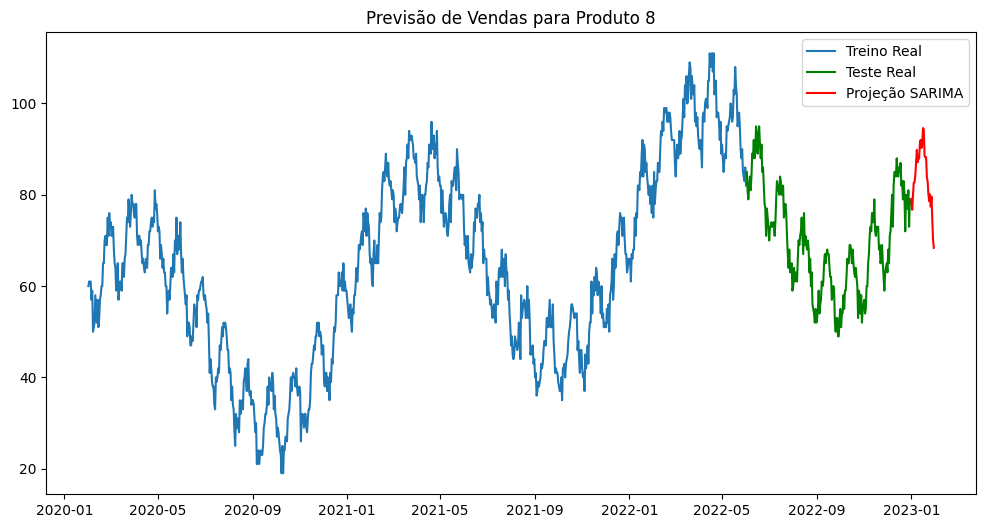

{1: {'MSE': 193.69701806749242, 'RMSE': 13.917507609751555, 'MAE': 12.262648671468664}, 2: {'MSE': 156.30028982725008, 'RMSE': 12.502011431255776, 'MAE': 10.445893637797905}, 3: {'MSE': 177.99019991144948, 'RMSE': 13.341296785224797, 'MAE': 9.611508412538653}, 4: {'MSE': 4.663619642478364, 'RMSE': 2.1595415352519534, 'MAE': 1.7310748280174737}, 5: {'MSE': 22.218885416928064, 'RMSE': 4.713691272975784, 'MAE': 4.1091267824938305}, 6: {'MSE': 89.1249323985367, 'RMSE': 9.440600213891948, 'MAE': 6.853081309630893}, 7: {'MSE': 181.23853127231413, 'RMSE': 13.462486073244946, 'MAE': 11.562161455266194}, 8: {'MSE': 7.169762055483545, 'RMSE': 2.6776411364265273, 'MAE': 2.184912341493769}}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


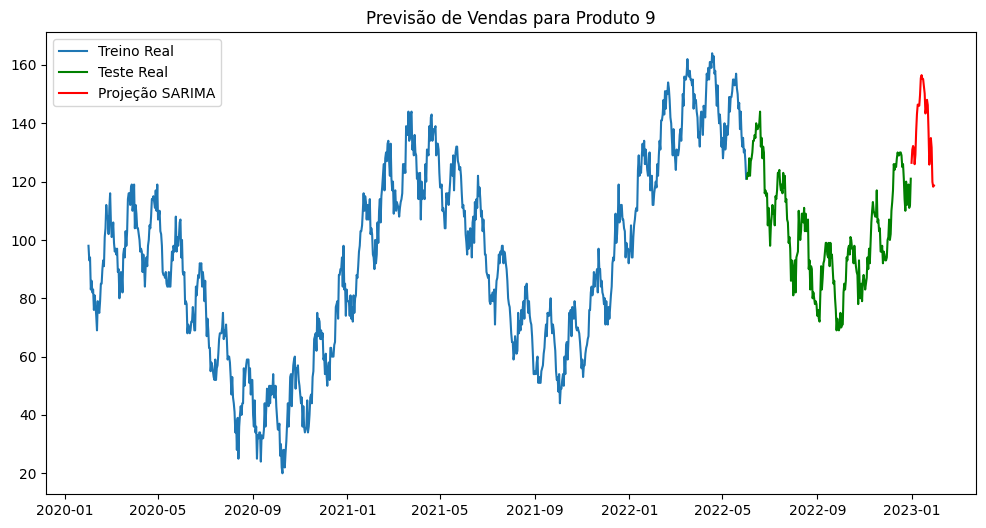

{1: {'MSE': 193.69701806749242, 'RMSE': 13.917507609751555, 'MAE': 12.262648671468664}, 2: {'MSE': 156.30028982725008, 'RMSE': 12.502011431255776, 'MAE': 10.445893637797905}, 3: {'MSE': 177.99019991144948, 'RMSE': 13.341296785224797, 'MAE': 9.611508412538653}, 4: {'MSE': 4.663619642478364, 'RMSE': 2.1595415352519534, 'MAE': 1.7310748280174737}, 5: {'MSE': 22.218885416928064, 'RMSE': 4.713691272975784, 'MAE': 4.1091267824938305}, 6: {'MSE': 89.1249323985367, 'RMSE': 9.440600213891948, 'MAE': 6.853081309630893}, 7: {'MSE': 181.23853127231413, 'RMSE': 13.462486073244946, 'MAE': 11.562161455266194}, 8: {'MSE': 7.169762055483545, 'RMSE': 2.6776411364265273, 'MAE': 2.184912341493769}, 9: {'MSE': 155.68224366234972, 'RMSE': 12.477269078702667, 'MAE': 11.570803139961944}}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


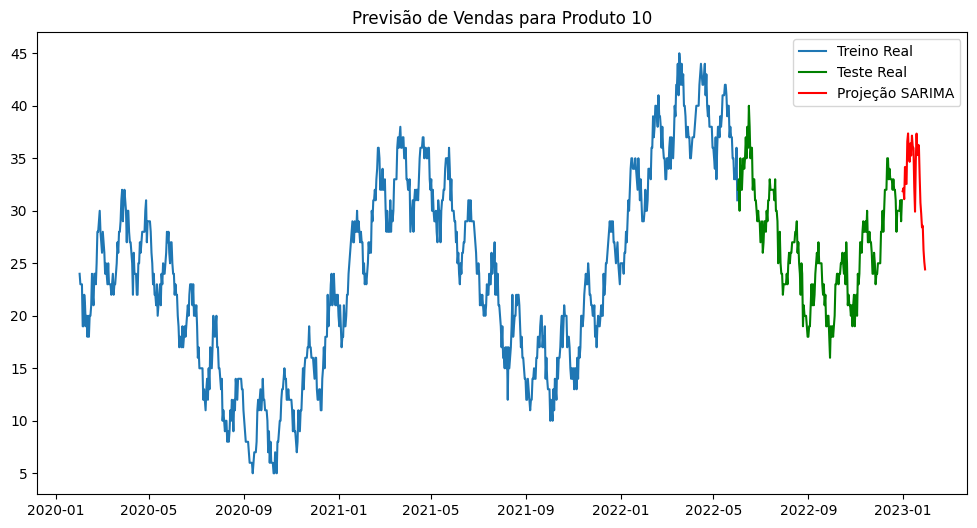

{1: {'MSE': 193.69701806749242, 'RMSE': 13.917507609751555, 'MAE': 12.262648671468664}, 2: {'MSE': 156.30028982725008, 'RMSE': 12.502011431255776, 'MAE': 10.445893637797905}, 3: {'MSE': 177.99019991144948, 'RMSE': 13.341296785224797, 'MAE': 9.611508412538653}, 4: {'MSE': 4.663619642478364, 'RMSE': 2.1595415352519534, 'MAE': 1.7310748280174737}, 5: {'MSE': 22.218885416928064, 'RMSE': 4.713691272975784, 'MAE': 4.1091267824938305}, 6: {'MSE': 89.1249323985367, 'RMSE': 9.440600213891948, 'MAE': 6.853081309630893}, 7: {'MSE': 181.23853127231413, 'RMSE': 13.462486073244946, 'MAE': 11.562161455266194}, 8: {'MSE': 7.169762055483545, 'RMSE': 2.6776411364265273, 'MAE': 2.184912341493769}, 9: {'MSE': 155.68224366234972, 'RMSE': 12.477269078702667, 'MAE': 11.570803139961944}, 10: {'MSE': 5.5430024763873025, 'RMSE': 2.35435818778437, 'MAE': 1.7933160295310249}}


In [32]:
# def modelar_previsoes_vendas(df_vendas, produtos):
#Criando as colunas de lag
for i in range(1, 60):
    df_vendas[f"lag_{i}"] = df_vendas.groupby('Produto_ID')['Quantidade Vendida'].shift(i)

df_vendas.fillna(df_vendas.mean(), inplace=True)
df_vendas.replace([np.inf, -np.inf], 0, inplace=True)

previsoes = {}
metricas = {}

for produto_id in df_produtos['Produto_ID']:
    data_produto = df_vendas[df_vendas['Produto_ID'] == produto_id].sort_values(by='Data').dropna()
    data_produto = data_produto[data_produto['Data'] >= '2020-02-01']

    train_size = int(len(data_produto) * 0.8)
    train = data_produto.iloc[:train_size]['Quantidade Vendida'].values
    test = data_produto.iloc[train_size:]['Quantidade Vendida'].values

    exog_train = data_produto.iloc[:train_size].drop(['Data', 'Produto_ID', 'Quantidade Vendida'], axis=1).values
    exog_test = data_produto.iloc[train_size:].drop(['Data', 'Produto_ID', 'Quantidade Vendida'], axis=1).values

    modelo = SARIMAX(train, exog=exog_train, order=(2, 1, 3), seasonal_order=(0, 0, 0, 24))
    modelo_treinado = modelo.fit(disp=False, maxiter=400)

    forecast = modelo_treinado.forecast(steps=30, exog=exog_test[:30])
    #Cálculo das métricas
    mse = mean_squared_error(test[:30], forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test[:30], forecast)
    metricas[produto_id] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae}

    if len(forecast) < 30:
        for i in range(30 - len(forecast)):
            last_exog = np.roll(exog_test[-1], shift=-1)
            last_exog[-1] = forecast[-1]
            next_forecast = modelo_treinado.forecast(steps=1, exog=last_exog.reshape(1, -1))
            forecast = np.append(forecast, next_forecast[0])
            exog_test = np.vstack([exog_test, last_exog])

    previsoes[produto_id] = forecast

    #Visualização
    plt.figure(figsize=(12, 6))
    #Plot dos dados de treinamento
    plt.plot(data_produto['Data'].values[:train_size], train, label='Treino Real')
    #Plot dos dados de teste
    plt.plot(data_produto['Data'].values[train_size:], test, label='Teste Real', color='green')
    #Plot das previsões
    forecast_dates = pd.date_range(data_produto['Data'].values[-1] + pd.Timedelta(days=1), periods=30, freq='D')
    plt.plot(forecast_dates, forecast, label='Projeção SARIMA', color='red')
    plt.title(f"Previsão de Vendas para Produto {produto_id}")
    plt.legend()
    plt.show()

    print(metricas)
    # return previsoes

In [68]:
#Função para sugestões de compras
# def sugerir_compras(df_estoque, df_lead_times, df_compras, previsoes, produtos):
# Tratar dados
# df_estoque = tratar_dados(df_estoque)
# df_lead_times = tratar_dados(df_lead_times)
# df_compras = tratar_dados(df_compras)
# Supondo que produtos seja um DataFrame
#produtos = tratar_dados(produtos)

# Suposições
custo_manter_estoque_por_dia_por_unidade = 0.005  # 0.5% do custo do produto

# Listas e dicionários para guardar informações para o dashboard
sugestoes_compra = []
estoques_abaixo_minimo = []
custos_manutencao_estoque = []
dict_estoque_minimo = {}

# Verificar compras pendentes
compras_pendentes = df_compras[(df_compras['Status'] == 'Pendente')]

# Loop principal para cada produto
for produto_id in df_produtos['Produto_ID']:
    estoque_atual = df_estoque[df_estoque['Produto_ID'] == produto_id]['Quantidade_Estoque'].values[-1]
    demanda_mensal = previsoes[produto_id].sum()
    lead_time = df_lead_times[df_lead_times['Produto_ID'] == produto_id]['Lead_Time_Dias'].mean()
    fornecedores_produto = df_lead_times[df_lead_times['Produto_ID'] == produto_id]['Fornecedor_ID']
    numero_fornecedores = len(fornecedores_produto.unique())

    # Cálculo do estoque mínimo
    estoque_minimo = calcular_estoque_minimo(demanda_mensal, lead_time, numero_fornecedores)
    dict_estoque_minimo[produto_id] = estoque_minimo

    # Verificar se o estoque atual está abaixo do mínimo
    if estoque_atual < estoque_minimo:
        estoques_abaixo_minimo.append(produto_id)

    # Avaliar custo de manter o estoque
    custo_produto = df_produtos[df_produtos['Produto_ID'] == produto_id]['Custo_Unitario'].values[0]
    custo_manutencao = estoque_atual * custo_produto * custo_manter_estoque_por_dia_por_unidade
    custos_manutencao_estoque.append((produto_id, custo_manutencao))

    # Sugerir compras para produtos abaixo do estoque mínimo
    if produto_id in estoques_abaixo_minimo:
        quantidade_pendente = 0
        if produto_id in compras_pendentes['Produto_ID'].values:
            quantidade_pendente = compras_pendentes[compras_pendentes['Produto_ID'] == produto_id]['Quantidade'].values[-1]

        demanda_durante_lead_time = sum(previsoes[produto_id][:int(lead_time)-1])

        # Cálculo da quantidade a ser comprada
        quantidade_comprar = max(demanda_durante_lead_time, estoque_minimo) - (estoque_atual + quantidade_pendente)

        if quantidade_comprar > 0:
            sugestoes_compra.append((produto_id, quantidade_comprar))
        print(produto_id)
        print(estoque_atual)
        print(quantidade_pendente)
        print(demanda_durante_lead_time)
        print(estoque_minimo)
        print(quantidade_comprar)
        print(demanda_mensal )

# Convertendo dicionário para DataFrame
df_estoque_minimo = pd.DataFrame(list(dict_estoque_minimo.items()), columns=['Produto_ID', 'Estoque_Minimo'])
df_estoque_minimo


1
60
0
415.89124391606435
662.7166056518618
602.7166056518618
1840.8794601440602
2
10
0
1490.601084502715
2560.655788918228
2550.655788918228
4655.737798033142
3
5
0
1326.9185616175673
1771.909592244408
1766.909592244408
4218.832362486686
4
43
0
473.2906513469278
637.3795219652253
594.3795219652253
1327.8740040942191
5
5
0
339.07650950887717
613.7138490402668
608.7138490402668
1534.2846226006673
6
67
0
1891.051665986482
2562.2221862207857
2495.2221862207857
5124.444372441571
7
61
0
892.7206965220986
1306.4025440441767
1245.4025440441767
4082.5079501380524
8
71
0
749.1065899339894
1007.8702055996092
936.8702055996092
2519.675513999023
9
69
0
1203.0256277192034
1751.0321195635206
1682.0321195635206
4169.124094198859
10
69
0
161.9013311374973
256.8471826120752
187.8471826120752
987.8737792772123


,Produto_ID,Estoque_Minimo
0,1,662.716606
1,2,2560.655789
2,3,1771.909592
3,4,637.379522
4,5,613.713849
5,6,2562.222186
6,7,1306.402544
7,8,1007.870206
8,9,1751.032120
9,10,256.847183


In [59]:
df_estoque[df_estoque['Produto_ID'] == 1]['Quantidade_Estoque'].values[-1]

60

In [58]:
sugestoes_compra

[(1, 583.7166056518618),
 (2, 2468.655788918228),
 (3, 1743.909592244408),
 (4, 630.3795219652253),
 (5, 587.7138490402668),
 (6, 2505.2221862207857),
 (7, 1300.4025440441767),
 (8, 915.8702055996092),
 (9, 1717.0321195635206),
 (10, 214.8471826120752)]

Agora vamos validar se as sugestões do modelo estão fazendo sentido. Vamos usar o produto 1 como exemplo.

In [60]:
df_vendas[df_vendas['Produto_ID']==1].tail(31)

,Produto_ID,Data,Quantidade Vendida,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_50,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59
1795,1,2022-12-01,37,33.0,32.0,38.0,34.0,36.0,36.0,35.0,...,39.0,36.0,36.0,34.0,34.0,31.0,32.0,33.0,28.0,28.0
1796,1,2022-12-02,36,37.0,33.0,32.0,38.0,34.0,36.0,36.0,...,36.0,39.0,36.0,36.0,34.0,34.0,31.0,32.0,33.0,28.0
1797,1,2022-12-03,40,36.0,37.0,33.0,32.0,38.0,34.0,36.0,...,40.0,36.0,39.0,36.0,36.0,34.0,34.0,31.0,32.0,33.0
1798,1,2022-12-04,40,40.0,36.0,37.0,33.0,32.0,38.0,34.0,...,39.0,40.0,36.0,39.0,36.0,36.0,34.0,34.0,31.0,32.0
1799,1,2022-12-05,42,40.0,40.0,36.0,37.0,33.0,32.0,38.0,...,39.0,39.0,40.0,36.0,39.0,36.0,36.0,34.0,34.0,31.0
1800,1,2022-12-06,41,42.0,40.0,40.0,36.0,37.0,33.0,32.0,...,39.0,39.0,39.0,40.0,36.0,39.0,36.0,36.0,34.0,34.0
1801,1,2022-12-07,43,41.0,42.0,40.0,40.0,36.0,37.0,33.0,...,39.0,39.0,39.0,39.0,40.0,36.0,39.0,36.0,36.0,34.0
1802,1,2022-12-08,44,43.0,41.0,42.0,40.0,40.0,36.0,37.0,...,37.0,39.0,39.0,39.0,39.0,40.0,36.0,39.0,36.0,36.0
1803,1,2022-12-09,50,44.0,43.0,41.0,42.0,40.0,40.0,36.0,...,38.0,37.0,39.0,39.0,39.0,39.0,40.0,36.0,39.0,36.0
1804,1,2022-12-10,47,50.0,44.0,43.0,41.0,42.0,40.0,40.0,...,36.0,38.0,37.0,39.0,39.0,39.0,39.0,40.0,36.0,39.0


In [61]:
df_vendas[df_vendas['Produto_ID']==1].tail(31)['Quantidade Vendida'].sum()

1392

In [62]:
previsoes[1].sum()

1840.8794601440602

As vendas do produto 1 em dezembro foram 1392 e para janeiro estamos estimando uma alta de 1.840, isso faz sentido com o que vimos de evolução nos gráficos de validação do modelo.

In [63]:
df_lead_times[df_lead_times['Produto_ID']==1]

,Unnamed: 0,Fornecedor_ID,Produto_ID,Lead_Time_Dias,Criticidade
0,0,1,1,9,0
1,1,11,1,9,0


O lead time é de 9 dias

In [64]:
previsoes[1][:8].sum()

415.89124391606435

Então a sugestão de compra irá considerar esse período de 9 dias, a previsão de venda para 9 dias do produto 1 é de 415 unidades

In [65]:
df_estoque[df_estoque['Produto_ID']==1].tail(1)

,Unnamed: 0,Data,Produto_ID,Quantidade_Estoque,Data_tratada
18250,18250,2022-12-31,1,60,2022-12-31


A quantidade de estoque é de 60.

Vamos assumir que provavelmente a demanda por ter uma alta vai ser maior do que o estoque mínimo do produto que considera uma média da demanda dos períodos anteriores. Portanto a nossa sugestão de compra deveria ser projeção de vendas - estoque atual, no caso, seria 415 - 60 = 355

In [42]:
sugestoes_compra

[(1, 355.89124391606435),
 (2, 1480.601084502715),
 (3, 1321.9185616175673),
 (4, 431.17941405306186),
 (5, 334.07650950887717),
 (6, 1824.051665986482),
 (7, 831.7206965220986),
 (8, 678.1065899339894),
 (9, 1134.0256277192034),
 (10, 187.8471826120752)]

É extamente o valores que temos na sugestão de compra do item 1

In [43]:
# previsoes = modelar_previsoes_vendas(df_vendas, df_produtos)
# Executando as sugestões de compras
# sugestoes_compra = sugerir_compras(df_estoque, df_lead_times, df_compras, previsoes, df_produtos)

In [49]:
df_sugestoes = pd.DataFrame(sugestoes_compra, columns=['ID_Produto','Sugestao_Compra'])
df_sugestoes.to_csv("sugestoes.csv")
df_sugestoes

,ID_Produto,Sugestao_Compra
0,1,355.891244
1,2,1480.601085
2,3,1321.918562
3,4,431.179414
4,5,334.076510
5,6,1824.051666
6,7,831.720697
7,8,678.106590
8,9,1134.025628
9,10,187.847183


In [53]:
previsoes

{1: array([48.63888636, 50.47168989, 51.25150138, 51.17210466, 51.40863349,
        53.86365324, 54.19597476, 54.88880014, 56.80938021, 60.41493948,
        64.42942298, 68.96692632, 70.09909849, 69.28459389, 67.38850698,
        66.19810759, 67.00278031, 68.42425418, 67.73247834, 66.7361248 ,
        65.29093642, 64.91045795, 64.6548214 , 61.65143534, 60.88278611,
        62.0866483 , 63.78430621, 63.94942028, 63.62080802, 60.66998264]),
 2: array([140.18049445, 139.11901132, 143.04168032, 146.4279937 ,
        147.45336602, 149.28850095, 159.23278803, 154.54350929,
        149.5894646 , 161.72427584, 175.94255135, 166.63010778,
        165.29862481, 175.90006104, 178.61145179, 172.66634848,
        169.90792071, 163.63738295, 158.72716466, 156.96251018,
        158.02323853, 149.07117924, 146.27509138, 143.25489344,
        144.57806392, 150.1212749 , 146.10511086, 144.34703825,
        148.80793343, 150.26876584]),
 3: array([140.56657073, 144.40836238, 154.06976746, 159.8017627 ,
 

In [54]:
df_previsoes = pd.DataFrame(previsoes)
df_previsoes.to_csv("previsoes.csv")
df_previsoes

,1,2,3,4,5,6,7,8,9,10
0,48.638886,140.180494,140.566571,42.323024,49.129911,165.931431,131.802707,79.118194,126.441491,31.864671
1,50.471690,139.119011,144.408362,41.044712,46.108291,165.886501,122.986554,76.721477,130.967871,32.151650
2,51.251501,143.041680,154.069767,40.711866,46.933253,162.931522,129.653045,79.804369,132.213910,31.106041
3,51.172105,146.427994,159.801763,40.814159,48.427203,162.571326,134.001212,82.625178,131.450509,34.170317
4,51.408633,147.453366,144.953196,40.695563,48.976293,163.413567,123.733431,82.744345,125.972524,32.608652
5,53.863653,149.288501,146.168310,44.261019,50.015007,169.504705,122.479284,84.229563,129.157221,32.554319
6,54.195975,159.232788,145.728038,44.436869,49.486551,171.160054,128.064464,86.889509,137.320870,36.612420
7,54.888800,154.543509,150.722220,43.920382,52.251251,170.055126,128.858998,89.829016,143.103184,37.365502
8,56.809380,149.589465,140.500334,45.271094,51.637374,178.549134,129.056042,87.144939,146.398048,35.258721
9,60.414939,161.724276,135.214480,44.588648,50.453334,191.893518,137.300397,87.977819,146.284373,34.665188


In [69]:
df_estoque_minimo.to_csv("df_estoque_minimo.csv")

In [70]:
# itens_mercado = [
#     "Arroz", "Feijão", "Açúcar", "Sal", "Óleo",
#     "Macarrão", "Café", "Leite", "Ovos", "Farinha"
# ]

# # Adicionar a nova coluna
# df_produtos['Nome_Produto'] = itens_mercado

In [72]:
df_produtos.to_csv("df_produtos.csv")
df_produtos

,Unnamed: 0,Produto_ID,Nome_Produto,Custo_Unitario
0,0,1,Arroz,43
1,1,2,Feijão,33
2,2,3,Açúcar,19
3,3,4,Sal,47
4,4,5,Óleo,12
5,5,6,Macarrão,25
6,6,7,Café,43
7,7,8,Leite,23
8,8,9,Ovos,27
9,9,10,Farinha,15
